In [98]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd


def cluster(df, num_clusters, labels):
    """
    Clusters the df into num_clusters, and selects 45% of the data points with strictly postive NAS belonging
    to the clusters with the lowest fraction of NAS delays and sets the NAS delay column of the df to 0. All 
    other NAS delay column values equal to NAS delay. Returns df with new NAS and Cluster columns.
    """
    
    #Fit df to num_clusters using MiniBatchKMeans and append cluster labels to df
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, init_size=600, random_state=0)
    kmeans = kmeans.fit(df.values)
    cluster_labels = kmeans.labels_
    df["Cluster"] = cluster_labels

    #Create NAS column, still need to reject some of these
    df['NAS'] = labels["0"]

    #Get size and NAS ratio of each cluster and store in array of tuples
    clusters = []
    for cluster in df["Cluster"].unique():
        tmp = df[df["Cluster"] == cluster]
        denominator = len(tmp.index)
        tmp = tmp[tmp["NAS"] != 0]
        numerator = len(tmp.index)
        clusters.append([cluster, (numerator / denominator), denominator])

    #sort clusters in descending order of NAS ratio (second entry in each tuple)
    clusters.sort(key = lambda tup: tup[1], reverse=True)

    #Accept clusters in descending order of NAS ratio until we reach 55% of the NAS delays
    num_rejected = 0
    rejected = []
    num_nas = float(len(df[df['NAS'] != 0].index))
    for entry in clusters:
        if((float(num_rejected) / num_nas) > 0.45):
            break
        rejected.append(entry[0])
        num_rejected += (entry[2] * entry[1])
        clusters.remove(entry)
        
    # Set value of all rejected clusters to zero
    df.loc[df['Cluster'].isin(rejected), 'NAS'] = 0
    return df


def do_cluster(feature_file, label_file, save_file, num_clusters):
    """
    Read Data, remove non-weather features for clustering, cluster, and add results from the clustering to
    the df to create df with all features and all NAS delays accepted as being caused by weather.
    """
    labels = pd.read_csv(label_file)
    df = pd.read_csv(feature_file)
    del df['Unnamed: 0']
    del df["OFFSET"]

    remove = ['OP_UNIQUE_CARRIERWN', 'OP_UNIQUE_CARRIERAS',
           'OP_UNIQUE_CARRIERF9', 'OP_UNIQUE_CARRIERB6', 'OP_UNIQUE_CARRIERDL',
           'OP_UNIQUE_CARRIERUA', 'OP_UNIQUE_CARRIERAA', 'OP_UNIQUE_CARRIERNK',
           'OP_UNIQUE_CARRIEROO', 'OP_UNIQUE_CARRIERYX', 'OP_UNIQUE_CARRIER9E',
           'OP_UNIQUE_CARRIERVX', 'ORIGINSEA', 'ORIGINLAX', 'ORIGINMCO', 'ORIGINSFO',
           'ORIGINJFK', 'ORIGINATL', 'ORIGINDEN', 'ORIGINLAS', 'ORIGINDFW',
           'DESTDEN', 'DESTLAX', 'DESTJFK', 'DESTMCO', 'DESTLAS', 'DESTSEA',
           'DESTATL', 'DESTSFO', 'DESTDFW']
    df_cluster = df.drop(remove, axis=1)
    del labels['Unnamed: 0']
    c = cluster(df_cluster, num_clusters, labels)

    df['Cluster'] = c['Cluster']
    df['NAS'] = c['NAS']
    df.to_csv(save_file)

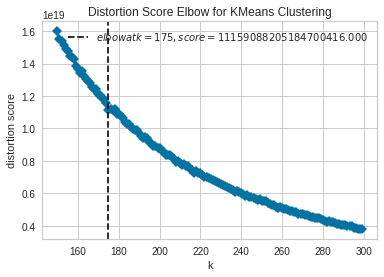

In [40]:
# Read Data, clean useless columns
df = pd.read_csv("X.csv")
del df['Unnamed: 0']
del df["OFFSET"]

# Remove onehot carrier
remove = ['OP_UNIQUE_CARRIERWN', 'OP_UNIQUE_CARRIERAS',
       'OP_UNIQUE_CARRIERF9', 'OP_UNIQUE_CARRIERB6', 'OP_UNIQUE_CARRIERDL',
       'OP_UNIQUE_CARRIERUA', 'OP_UNIQUE_CARRIERAA', 'OP_UNIQUE_CARRIERNK',
       'OP_UNIQUE_CARRIEROO', 'OP_UNIQUE_CARRIERYX', 'OP_UNIQUE_CARRIER9E',
       'OP_UNIQUE_CARRIERVX']
df = df.drop(remove, axis=1)

#Remove one hot for destination and airport
remove = ['ORIGINSEA', 'ORIGINLAX', 'ORIGINMCO', 'ORIGINSFO',
       'ORIGINJFK', 'ORIGINATL', 'ORIGINDEN', 'ORIGINLAS', 'ORIGINDFW',
       'DESTDEN', 'DESTLAX', 'DESTJFK', 'DESTMCO', 'DESTLAS', 'DESTSEA',
       'DESTATL', 'DESTSFO', 'DESTDFW']
df = df.drop(remove, axis=1).to_numpy()

# Create Elbow visualizer to help determine number of clusers
visualizer = KElbowVisualizer(KMeans(), k=(150,300),timings=False)
visualizer.fit(df)
visualizer.show()

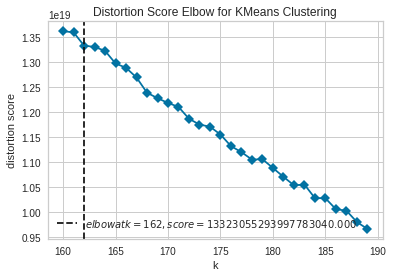

In [86]:
# Create another visualizer with range closer to the elbow
visualizer = KElbowVisualizer(KMeans(), k=(160,190),timings=False)
visualizer.fit(df)
visualizer.show()

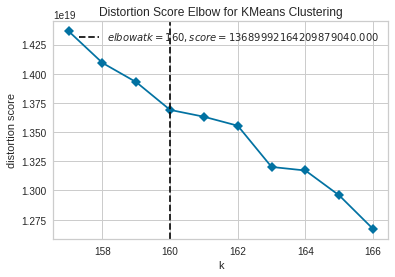

In [87]:
# And again
visualizer = KElbowVisualizer(KMeans(), k=(157,167),timings=False)
visualizer.fit(df)
visualizer.show()

In [99]:
n_clusters = 160
do_cluster("X.csv", "NAS_train.csv", 'Clustered_train.csv', n_clusters)
do_cluster("X_test.csv", "NAS_test.csv", 'Clustered_test.csv', n_clusters)